In [1]:
!pip install ujson 
!pip install seaborn

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/f8/8c/5274ba7b4df814c87a8840a58e2b1dae6a489f49c3b0fad2d15f1e41d47b/ujson-5.3.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (45 kB)
You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/10/5b/0479d7d845b5ba410ca702ffcd7f2cd95a14a4dfff1fde2637802b258b9b/seaborn-0.11.2-py3-none-any.whl (292 kB)
You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.


In [1]:
import sys 
sys.path.append('../')

In [3]:
import os
from pathlib import Path
import torch
from PIL import Image
import pandas as pd 
import sys 
import json 
from src import dataset_lvis
from src import metrics
from src import helper_functions as helper
import importlib
from pathlib import Path 
from PIL import Image as PILImage
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import pandas as pd 
import time 
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()

ModuleNotFoundError: No module named 'src'

In [3]:
importlib.reload(dataset_lvis)

<module 'src.dataset_lvis' from '/home/INM705_CW_Collins_Velagala/notebooks/../src/dataset_lvis.py'>

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Load train and validation data 

In [5]:
time_start = time.time()

data_args = {'stage': 'train',
            'classes': ['cowboy_hat', 'coffee_maker', 'monkey',
                        'cappuccino', 'drumstick', 'chessboard',
                        'horse_buggy', 'armor', 'smoothie'], 
            'ds_path' : "../Datasets/coco/",
            'labels_dir': "annotations",
            'images_dir': 'images',
             'height' : 480,
             'width' : 640,
            'max_negative' : 0}
train_data = dataset_lvis.LVISData(**data_args)

print(f'Time taken to initialize train set: {time.time()-time_start}')

classes : {1: 'armor', 2: 'horse_buggy', 3: 'cappuccino', 4: 'chessboard', 5: 'coffee_maker', 6: 'cowboy_hat', 7: 'drumstick', 8: 'monkey', 9: 'smoothie'}
loaded 645 positive set images
loaded 0 negative set images
loaded 30 non-exhaustive set images
Loaded 615 images!
class 1 has 7 positive and 0 negative images
class 2 has 7 positive and 0 negative images
class 3 has 71 positive and 0 negative images
class 4 has 9 positive and 0 negative images
class 5 has 233 positive and 0 negative images
class 6 has 199 positive and 0 negative images
class 7 has 8 positive and 0 negative images
class 8 has 73 positive and 0 negative images
class 9 has 8 positive and 0 negative images
1033 annotations found!
stage:  train
classes:  {'armor': 21, 'horse_buggy': 161, 'cappuccino': 206, 'chessboard': 240, 'coffee_maker': 284, 'cowboy_hat': 319, 'drumstick': 400, 'monkey': 699, 'smoothie': 974}
ds_path:  ../Datasets/coco/
labels_f:  ../Datasets/coco/annotations/lvis_v1_train.json
imgs_dir:  ../Datasets

### Split train set into custom train val set

Validation set reserved for testing

Check that we don't have too many of the rare cases in validation set - if so then there won't be much data to actually train on.

In [6]:
# what images have what classes?
g_cpu = torch.Generator()
g_cpu.manual_seed(3)

#Split dataset to test and train
indices = torch.randperm(len(train_data), generator=g_cpu).tolist()


dataset_train = torch.utils.data.Subset(train_data, indices[:550])
dataset_val = torch.utils.data.Subset(train_data, indices[550:])


class_counts = dict(zip(range(1,10), [0]*9))
for _, _, y in dataset_val:
    for label in y['labels']:
        class_counts[label.item()] += 1
            
class_counts

{1: 0, 2: 0, 3: 8, 4: 1, 5: 31, 6: 44, 7: 0, 8: 22, 9: 1}

## Prepare test set

The LVIS validation set is reserved for our test set

In [7]:
time_start = time.time() 
data_args = {'stage': 'val',
            'classes': ['cowboy_hat', 'coffee_maker', 'monkey',
                        'cappuccino', 'drumstick', 'chessboard',
                        'horse_buggy', 'armor', 'smoothie'], 
            'ds_path' : "../Datasets/coco/",
            'labels_dir': "annotations",
            'images_dir': 'images',
             'height' : 480,
             'width' : 640,
            'max_negative' : 200}   # note that we include negative sets for the testing
test_data = dataset_lvis.LVISData(**data_args)
print(f'Time taken to initialize val set: {time.time()-time_start}')

classes : {1: 'armor', 2: 'horse_buggy', 3: 'cappuccino', 4: 'chessboard', 5: 'coffee_maker', 6: 'cowboy_hat', 7: 'drumstick', 8: 'monkey', 9: 'smoothie'}
loaded 128 positive set images
loaded 1466 negative set images
loaded 3 non-exhaustive set images
Loaded 1584 images!
class 1 has 1 positive and 189 negative images
class 2 has 6 positive and 183 negative images
class 3 has 17 positive and 189 negative images
class 4 has 1 positive and 186 negative images
class 5 has 46 positive and 172 negative images
class 6 has 39 positive and 188 negative images
class 7 has 2 positive and 111 negative images
class 8 has 12 positive and 182 negative images
class 9 has 2 positive and 123 negative images
191 annotations found!
stage:  val
classes:  {'armor': 21, 'horse_buggy': 161, 'cappuccino': 206, 'chessboard': 240, 'coffee_maker': 284, 'cowboy_hat': 319, 'drumstick': 400, 'monkey': 699, 'smoothie': 974}
ds_path:  ../Datasets/coco/
labels_f:  ../Datasets/coco/annotations/lvis_v1_val.json
imgs_dir

# Fine-tuning the model

Here we set `pretrained = False` for the FPN: FPN is pre-trained on coco dataset so we'll try to retrain from scratch. We keep the backbone ResNet50 pretrained on ImageNet.

In [1]:
      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

# Set up DataLoaders

In [2]:

train_loader = torch.utils.data.DataLoader(
 dataset_train, batch_size=4, shuffle=True, #num_workers=4,
 collate_fn=helper.CollateCustom())

val_loader = torch.utils.data.DataLoader(
 dataset_val, batch_size=4, shuffle=True, #num_workers=4,
 collate_fn=helper.CollateCustom())


NameError: name 'torch' is not defined

# Initialize Model + Model params

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has 10 classes - background and 9 specified objects
num_classes = 10

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Train Model

In [11]:
num_epochs = 16
time_start = time.time() 


train_loss_df = pd.DataFrame(columns = ['epoch', 'loss_classifier', 'loss_box_reg', 'loss_mask', 'loss_objectness', 'loss_rpn_box_reg', 'total_loss'])
val_loss_df = pd.DataFrame(columns = ['epoch', 'loss_classifier', 'loss_box_reg', 'loss_mask', 'loss_objectness', 'loss_rpn_box_reg', 'total_loss'])

loss_types = ['loss_classifier', 'loss_box_reg', 'loss_mask', 'loss_objectness', 'loss_rpn_box_reg', 'total_loss']


for epoch in range(num_epochs):
    model.train()
    
    train_loss = dict.fromkeys(loss_types, 0) 
    val_loss = dict.fromkeys(loss_types, 0) 
    
    """
    Train 
    """
    for batch_num, (idx, X, y) in enumerate(train_loader):
        #print(idx)
        X = X.to(device)
        y = [{k: v.to(device) for k, v in t.items()} for t in y]
        
        loss_dict = model(X, y) 
        
        losses = sum(loss for loss in loss_dict.values())
        
        #save losses
        for key in loss_types:
            if key != 'total_loss':
                train_loss[key] += loss_dict[key].item()
            else: 
                train_loss['total_loss'] += losses.item()
                

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
    row = pd.DataFrame({'epoch': [epoch],
          'loss_classifier': [train_loss['loss_classifier']/(batch_num+1)],
          'loss_box_reg' : [train_loss['loss_box_reg']/(batch_num+1)],
           'loss_mask': [train_loss['loss_mask']/(batch_num+1)],
           'loss_objectness': [train_loss['loss_objectness']/(batch_num+1)],
           'loss_rpn_box_reg': [train_loss['loss_rpn_box_reg']/(batch_num+1)],
            'total_loss': [train_loss['total_loss']/(batch_num+1)] 
          })     

    train_loss_df = pd.concat([train_loss_df, row], ignore_index = True, axis = 0)
    
    print(f"Training loss after {epoch} epochs: {train_loss['total_loss']}")

    
    """
    Validation
    """
    with torch.no_grad():
        for batch_num, (idx, X, y) in enumerate(val_loader):
            X = X.to(device)
            y = [{k: v.to(device) for k, v in t.items()} for t in y]

            loss_dict = model(X, y) 
            
            losses_val = sum(loss for loss in loss_dict.values())
            
            #save losses
            for key in loss_types:
                if key != 'total_loss':
                    val_loss[key] += loss_dict[key].item()
                else: 
                    val_loss['total_loss'] += losses_val.item()
                    
        row = pd.DataFrame({'epoch': [epoch],
                          'loss_classifier': [val_loss['loss_classifier']/(batch_num+1)],
                          'loss_box_reg' : [val_loss['loss_box_reg']/(batch_num+1)],
                           'loss_mask': [val_loss['loss_mask']/(batch_num+1)],
                           'loss_objectness': [val_loss['loss_objectness']/(batch_num+1)],
                           'loss_rpn_box_reg': [val_loss['loss_rpn_box_reg']/(batch_num+1)],
                            'total_loss': [val_loss['total_loss']/(batch_num+1)] 
                          })
        val_loss_df = pd.concat([val_loss_df, row], ignore_index = True, axis = 0)

    print(f"Validation loss after {epoch} epochs: {val_loss['total_loss']}") 
    print(f'Time elapsed for {epoch} epochs: {time.time()-time_start}') 

      
    """
    Save checkpoints and losses every 5 epoch
    """
    if epoch%5 == 0: 
        checkpoint = {"state_dict": model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "step": epoch,
                        "ds_args" : data_args
                        }
        fname = "model_" + str(epoch) + "_epochs.pth"
        helper.save_checkpoint(checkpoint, fname)
        print(f'Time elapsed after {epoch} epochs: {time.time()-time_start}')  
        val_loss_df.to_csv(Path.cwd().parent.joinpath("val_loss.csv"))
        train_loss_df.to_csv(Path.cwd().parent.joinpath("train_loss.csv"))

    
    
    #for final epoch 
    if epoch == num_epochs-1: 
        helper.save_model(model.state_dict(), "model.pth")
        val_loss_df.to_csv(Path.cwd().parent.joinpath("val_loss.csv"))
        train_loss_df.to_csv(Path.cwd().parent.joinpath("train_loss.csv"))
    
    
    
print(f"Time elapsed for {epoch+1} epochs: {round((time.time()-time_start)/60, 2)} min")

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1153.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Training loss after 0 epochs: 107.04226484894753
Validation loss after 0 epochs: 10.1418876349926
Time elapsed for 0 epochs: 90.8040497303009
Saved checkpoint model_0_epochs.pth!
Time elapsed after 0 epochs: 92.33182263374329
Training loss after 1 epochs: 65.6443824917078
Validation loss after 1 epochs: 8.879241347312927
Time elapsed for 1 epochs: 182.31968092918396
Training loss after 2 epochs: 52.94097135961056
Validation loss after 2 epochs: 8.295908838510513
Time elapsed for 2 epochs: 272.96736192703247
Training loss after 3 epochs: 44.77424116432667
Validation loss after 3 epochs: 8.51430270075798
Time elapsed for 3 epochs: 364.0191922187805
Training loss after 4 epochs: 40.07083973288536
Validation loss after 4 epochs: 9.688126936554909
Time elapsed for 4 epochs: 455.12225580215454
Training loss after 5 epochs: 34.53039847314358
Validation loss after 5 epochs: 9.768614009022713
Time elapsed for 5 epochs: 546.3442640304565
Saved checkpoint model_5_epochs.pth!
Time elapsed after 5 

# Plot loss 

,train_loss,val_loss
0,0.775669,0.596582
1,0.475684,0.522308
2,0.38363,0.487995
3,0.324451,0.500841
4,0.290368,0.56989
5,0.25022,0.574624
6,0.234695,0.619601
7,0.218185,0.57492
8,0.206328,0.612508
9,0.2046,0.666756


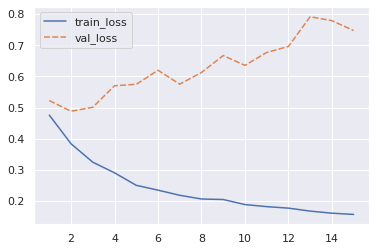

In [12]:
new_df = pd.DataFrame() 
#new_df['epoch'] = train_loss_df['epoch'] 
new_df['train_loss'] = train_loss_df['total_loss'] 
new_df['val_loss'] = val_loss_df['total_loss'] 

sns.lineplot(data = new_df[1:])
new_df


In [13]:
train_loss_df

,epoch,loss_classifier,loss_box_reg,loss_mask,loss_objectness,loss_rpn_box_reg,total_loss
0,0,0.188568,0.117114,0.395325,0.056581,0.018082,0.775669
1,1,0.102205,0.094743,0.240977,0.023562,0.014198,0.475684
2,2,0.080311,0.079507,0.201283,0.011842,0.010688,0.38363
3,3,0.064683,0.073887,0.168909,0.007252,0.00972,0.324451
4,4,0.055323,0.066417,0.155822,0.004929,0.007879,0.290368
5,5,0.038415,0.058625,0.142478,0.002562,0.008139,0.25022
6,6,0.033892,0.055731,0.136582,0.002086,0.006405,0.234695
7,7,0.030107,0.051451,0.128477,0.001532,0.006618,0.218185
8,8,0.026918,0.047947,0.12436,0.001335,0.005768,0.206328
9,9,0.025301,0.047942,0.123756,0.001191,0.006409,0.2046


In [14]:
val_loss_df

,epoch,loss_classifier,loss_box_reg,loss_mask,loss_objectness,loss_rpn_box_reg,total_loss
0,0,0.098342,0.087358,0.338142,0.057613,0.015128,0.596582
1,1,0.11349,0.080512,0.281323,0.032731,0.014253,0.522308
2,2,0.096381,0.081219,0.267518,0.02804,0.014837,0.487995
3,3,0.095023,0.084045,0.278452,0.029158,0.014163,0.500841
4,4,0.108364,0.068124,0.306936,0.048299,0.038167,0.56989
5,5,0.11849,0.07378,0.314407,0.051838,0.016109,0.574624
6,6,0.130198,0.079095,0.341253,0.05544,0.013616,0.619601
7,7,0.127833,0.07472,0.294363,0.061218,0.016786,0.57492
8,8,0.150729,0.080452,0.303348,0.061408,0.01657,0.612508
9,9,0.161779,0.076759,0.339255,0.07245,0.016513,0.666756


## Run the testing

In [15]:
importlib.reload(metrics)
importlib.reload(dataset_lvis)

<module 'src.dataset_lvis' from '/home/INM705_CW_Collins_Velagala/notebooks/../src/dataset_lvis.py'>

In [16]:
test_loader = torch.utils.data.DataLoader(
 test_data, batch_size=1, shuffle=True, #num_workers=4,
 collate_fn=helper.CollateCustom())

If testing at different time from training, then load checkpoints.

Or load checkpoints from earlier stopping point

In [57]:
cp_path = Path('../model_checkpoints/model_10_epochs.pth')
helper.load_checkpoint(cp_path, model, optimizer)


Loaded checkpoint ../model_checkpoints/model_10_epochs.pth!


In [33]:
list(np.around(np.arange(0.5, 1.0, 0.05),2))

[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

In [34]:
%%time

pred_boxes = []
gt = []
for idx, X, y in test_loader:
    model.eval()
    y_pred = model(X.to(device))
    # keep running list of predictions and ground truths
    pred_boxes, gt = metrics.store_preds(idx, y, y_pred,
                                     pred_boxes, gt)

mAP_list = []
thresholds = list(np.around(np.arange(0.5, 1.0, 0.05),2))
for iou_thresh in thresholds:
    mAP_list.append(metrics.calculate_ap(pred_boxes, gt, 
                               iou_threshold=iou_thresh,
                               class_datasets = test_data.class_datasets))

for i in range(len(thresholds)):
    print('mAP for iou_threshold of {}: {:.3f}'.format(thresholds[i], mAP_list[i][0]))




--------------


mAP for iou_threshold of 0.5: 0.196
mAP for iou_threshold of 0.55: 0.191
mAP for iou_threshold of 0.6: 0.188
mAP for iou_threshold of 0.65: 0.181
mAP for iou_threshold of 0.7: 0.155
mAP for iou_threshold of 0.75: 0.142
mAP for iou_threshold of 0.8: 0.119
mAP for iou_threshold of 0.85: 0.039
mAP for iou_threshold of 0.9: 0.020
mAP for iou_threshold of 0.95: 0.001
CPU times: user 5min 3s, sys: 10min 36s, total: 15min 39s
Wall time: 2min 14s


### Print out per category mAP

Table below shows the categories we have in rows, and different IoU thresholds in columns.

We also print the number of images in the test set containing each category. You can see that the model doesn't have much chance to prove itself on chessboard or drumstick categories!

In [38]:
df = pd.DataFrame(index = list(range(1, 10)), columns = ['positives'] + thresholds)

df['positives'] = [len(c['positive']) for c in test_data.class_datasets.values()]

for i in range(len(thresholds)):
    data = [v.item() for v in mAP_list[i][1].values()]
    df[thresholds[i]] = data

df.rename(index=test_data.idx_to_classname, inplace=True)
df.loc['frequent_mean'] = df[df.positives > 30].mean()
df.loc['common_mean'] = df[(df.positives < 30) & (df.positives > 8)].mean()
df.loc['rare_mean'] = df[df.positives < 8].mean()
df['class_mAP'] = df.iloc[:, 1:].mean(axis=1)
df.round(4)

,positives,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,class_mAP
armor,1.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
horse_buggy,6.0,0.0003,0.0003,0.0003,0.0003,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001
cappuccino,17.0,0.3715,0.3715,0.3715,0.3715,0.2591,0.2591,0.2204,0.1237,0.1099,0.0000,0.2458
chessboard,1.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
coffee_maker,46.0,0.7271,0.7271,0.7038,0.6636,0.6429,0.6210,0.5470,0.1787,0.0656,0.0052,0.4882
cowboy_hat,39.0,0.4786,0.4786,0.4786,0.4588,0.3636,0.2705,0.2066,0.0440,0.0089,0.0000,0.2788
drumstick,2.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
monkey,12.0,0.1023,0.0544,0.0544,0.0544,0.0466,0.0466,0.0176,0.0046,0.0000,0.0000,0.0381
smoothie,2.0,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0833,0.0000,0.0000,0.0000,0.0583
frequent_mean,42.5,0.6028,0.6028,0.5912,0.5612,0.5032,0.4457,0.3768,0.1113,0.0373,0.0026,0.3835
